In [ ]:
import os 
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

import torch
import torchvision 
from torchvision import transforms 
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights


%matplotlib inline 

In [ ]:
os.chdir('/content/drive/My Drive/HPE')

In [ ]:
!ls         # list directory

HPE.ipynb  images


In [ ]:
!pwd        # get current directory 

/content/drive/MyDrive/HPE


In [ ]:
data_dir = '/content/drive/MyDrive/HPE'
img_dir = os.path.join(data_dir, 'images')

# Step 1: Identify the list of human keypoints to track

In [ ]:
human_keypoints = ['nose', 'left_eye', 'right_eye', 
                   'left_ear', 'right_ear', 
                   'left_shoulder', 'right_shoulder', 
                   'left_elbow', 'right_elbow', 
                   'left_wrist', 'right_wrist', 
                   'left_hip', 'right_hip', 
                   'left_knee', 'right_knee', 
                   'left_ankle', 'right_ankle']

print(len(human_keypoints))

17


# Step 2: Identify possible connections between the keypoints 

Example: The left ear has a connection to the left eye.

In [ ]:
def possible_keypoint_connections(keypoints): 

    connections = [
        [keypoints.index('right_eye'), keypoints.index('nose')],
        [keypoints.index('right_eye'), keypoints.index('right_ear')],
        [keypoints.index('left_eye'), keypoints.index('nose')],
        [keypoints.index('left_eye'), keypoints.index('left_ear')],
        [keypoints.index('right_shoulder'), keypoints.index('right_elbow')],
        [keypoints.index('right_elbow'), keypoints.index('right_wrist')],
        [keypoints.index('left_shoulder'), keypoints.index('left_elbow')],
        [keypoints.index('left_elbow'), keypoints.index('left_wrist')],
        [keypoints.index('right_hip'), keypoints.index('right_knee')],
        [keypoints.index('right_knee'), keypoints.index('right_ankle')],
        [keypoints.index('left_hip'), keypoints.index('left_knee')],
        [keypoints.index('left_knee'), keypoints.index('left_ankle')],
        [keypoints.index('right_shoulder'), keypoints.index('left_shoulder')],
        [keypoints.index('right_hip'), keypoints.index('left_hip')],
        [keypoints.index('right_shoulder'), keypoints.index('right_hip')],
        [keypoints.index('left_shoulder'), keypoints.index('left_hip')]
    ]

    return connections 

In [ ]:
connections = possible_keypoint_connections(human_keypoints)

# Step 3: Load pretrained model from Pytorch

In [ ]:
pretrained_model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
pretrained_model.eval()    # inference mode 

# Step 4: Input image processing and modelling

The original image needs to be normalized before passing to the
model.

In [ ]:
img_path = os.path.join(img_dir, 'action_1.jpg')

# read the image 
img = cv2.imread(img_path)             

# preprocess input image
transform = transforms.Compose([        
    transforms.ToTensor()
])

img_tensor = transform(img)

# forward pass the model 
output = pretrained_model([img_tensor])[0]

# print model's output 
print(output.keys())

dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])


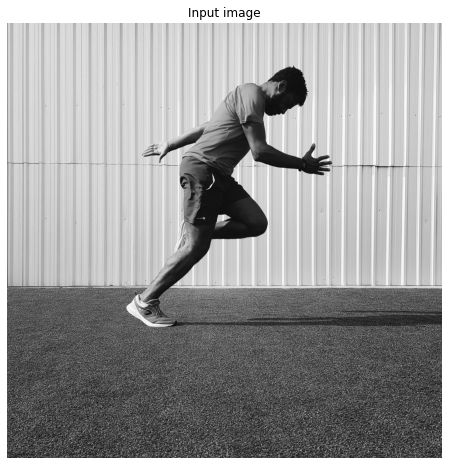

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title('Input image')
plt.axis('off')
plt.show()

# Step 5: Build custom function to plot the output

In [ ]:
def plot_keypoints(img, all_keypoints, all_scores, confs, 
                   keypoint_threshold=2, conf_threshold=0.9): 
    """Utility function to plot keypoints of a given input image.
    """

    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap('rainbow')

    # create a copy of the image
    img_copy = img.copy()

    # pick a set of N (uniform spaced) color-ids from the spectrum
    color_id = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]

    # iterate for every person detected
    for person_id in range(len(all_keypoints)):

        # check the confidence score of the detected person
        if confs[person_id] > conf_threshold:

            # grab the keypoint-locations for the detected person
            keypoints = all_keypoints[person_id, ...]

            # grab the keypoint-scores for the keypoints
            scores = all_scores[person_id, ...]

            # iterate for every keypoint-score
            for kp in range(len(scores)):

            # check the confidence score of detected keypoint
                if scores[kp] > keypoint_threshold:
                    # convert the keypoint float-array to a python-list of intergers
                    keypoint = tuple(map(int, keypoints[kp, :2].detach().numpy().tolist()))

                    # pick the color at the specific color-id
                    color = tuple(np.asarray(cmap(color_id[person_id])[:-1]) * 255)

                    # draw a cirle over the keypoint location
                    cv2.circle(img_copy, keypoint, 20, color, -1)

    return img_copy

In [ ]:
def plot_skeleton(img, all_keypoints, connections, all_scores, confs,
                  keypoint_threshold=2, conf_threshold=0.9):
    """Utility function to plot keypoints of a given input image.
    """

    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap('rainbow')

    # create a copy of the image
    img_copy = img.copy()

    # check if the keypoints are detected
    if len(output["keypoints"]) > 0:

        # pick a set of N color-ids from the spectrum
        colors = np.arange(1, 255, 255 // len(all_keypoints)).tolist()[::-1]

        # iterate for every person detected
        for person_id in range(len(all_keypoints)):

            # check the confidence score of the detected person
            if confs[person_id] > conf_threshold:

                # grab the keypoint-locations for the detected person
                keypoints = all_keypoints[person_id, ...]

                # iterate for every limb
                for conn_id in range(len(connections)):

                    # pick the start-point of the limb
                    limb_loc1 = keypoints[connections[conn_id][0], :2].detach().numpy().astype(np.int32)

                    # pick the start-point of the limb
                    limb_loc2 = keypoints[connections[conn_id][1], :2].detach().numpy().astype(np.int32)

                    # consider limb-confidence score as the minimum keypoint score among the two keypoint scores

                    limb_score = min(all_scores[person_id, 
                                                connections[conn_id][0]], 
                                                all_scores[person_id, connections[conn_id][1]])
                    
                    # check if limb-score is greater than threshold
                    if limb_score > keypoint_threshold:
                        # pick the color at a specific color-id
                        color = tuple(np.asarray(cmap(colors[person_id])[:-1]) * 255)

                        # draw the line for the limb
                        cv2.line(img_copy, tuple(limb_loc1), tuple(limb_loc2), color, 10)

    return img_copy

# Step 6: Plot the output on the input image

Plot the predicted keypoints and
skeleton onto the original image.

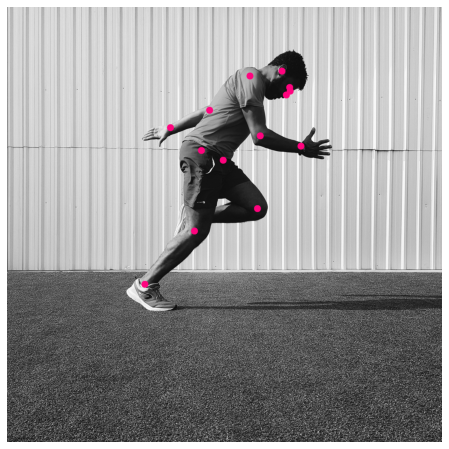

In [ ]:
keypoints_img = plot_keypoints(img, 
                               output["keypoints"], 
                               output["keypoints_scores"], 
                               output["scores"], 
                               keypoint_threshold=2)

cv2.imwrite("output/keypoints-img.jpg", keypoints_img)

plt.figure(figsize=(8, 8))
plt.imshow(keypoints_img[:, :, ::-1])
plt.axis('off')
plt.savefig(f'{img_dir}/keypoints_detect.png')
plt.show()

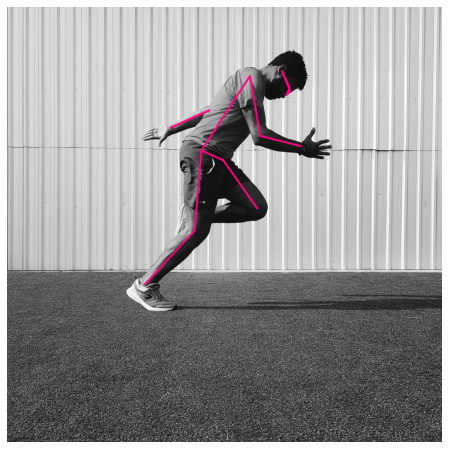

In [ ]:
skeleton_img = plot_skeleton(img, 
                             output["keypoints"],
                             connections, 
                             output["keypoints_scores"], 
                             output["scores"], 
                             keypoint_threshold=2)

cv2.imwrite("output/skeleton-img.jpg", skeleton_img)

plt.figure(figsize=(8, 8))
plt.imshow(skeleton_img[:, :, ::-1])
plt.axis('off')
plt.savefig(f'{img_dir}/skeleton_detect.png')
plt.show()

In [ ]:
img_path = os.path.join(img_dir, 'action_2.jpg')

# read the image 
img = cv2.imread(img_path)             

# preprocess input image
transform = transforms.Compose([        
    transforms.ToTensor()
])

img_tensor = transform(img)

# forward pass the model 
output = pretrained_model([img_tensor])[0]

# print model's output 
print(output.keys())

dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])


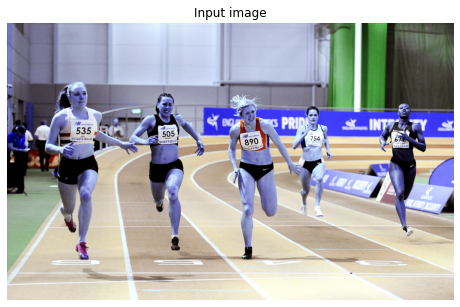

In [ ]:
plt.figure(figsize=(8, 8))

plt.imshow(img)
plt.title('Input image')
plt.axis('off')
plt.show()

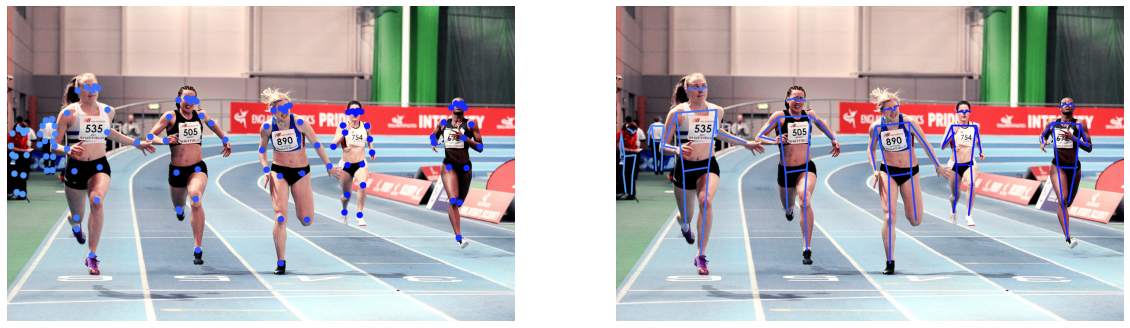

In [ ]:
# preidict for multiple people 
fig = plt.figure(figsize=(20, 8))

fig.add_subplot(1, 2, 1)
keypoints_img = plot_keypoints(img, 
                               output["keypoints"], 
                               output["keypoints_scores"], 
                               output["scores"], 
                               keypoint_threshold=2)
plt.imshow(keypoints_img[:, :, ::-1])
plt.axis('off')

fig.add_subplot(1, 2, 2)
skeleton_img = plot_skeleton(img, 
                             output["keypoints"],
                             connections, 
                             output["keypoints_scores"], 
                             output["scores"], 
                             keypoint_threshold=2)
plt.imshow(skeleton_img[:, :, ::-1])
plt.axis('off')

plt.savefig(f'{img_dir}/multiple_keypoints_skeleton_detect.png')
plt.show()

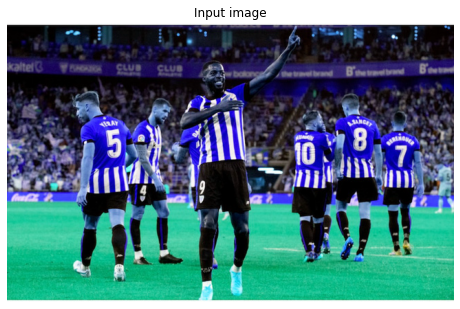

In [ ]:
img_path = os.path.join(img_dir, 'action_3.jpg')

# read the image 
img = cv2.imread(img_path)             

# preprocess input image
transform = transforms.Compose([        
    transforms.ToTensor()
])

img_tensor = transform(img)

# forward pass the model 
output = pretrained_model([img_tensor])[0]

plt.figure(figsize=(8, 8))

plt.imshow(img)
plt.title('Input image')
plt.axis('off')
plt.show()

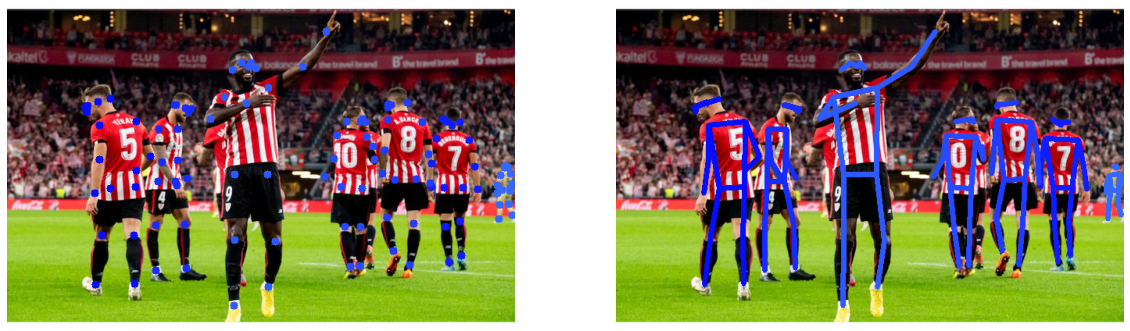

In [ ]:
# preidict for multiple people 
fig = plt.figure(figsize=(20, 8))

fig.add_subplot(1, 2, 1)
keypoints_img = plot_keypoints(img, 
                               output["keypoints"], 
                               output["keypoints_scores"], 
                               output["scores"], 
                               keypoint_threshold=2)
plt.imshow(keypoints_img[:, :, ::-1])
plt.axis('off')

fig.add_subplot(1, 2, 2)
skeleton_img = plot_skeleton(img, 
                             output["keypoints"],
                             connections, 
                             output["keypoints_scores"], 
                             output["scores"], 
                             keypoint_threshold=2)
plt.imshow(skeleton_img[:, :, ::-1])
plt.axis('off')

plt.savefig(f'{img_dir}/action_3_detect.png')
plt.show()